In [3]:
## En caso de que decidas trabajar localmente, se recomienda crear un ambiente
## e instalar las librerías. Además deberás cargar localmente las imágenes.
!pip install pandas
!pip install matplotlib
!pip install mediapipe
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled p

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
from tqdm import tqdm
import kagglehub

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
%cd /content/drive/My Drive/Data-IIC2613/

/content/drive/My Drive/Data-IIC2613


##### Este codigo genera los datasets con los landmarks automáticamente. No modificar.

In [26]:
path = kagglehub.dataset_download("glushko/rock-paper-scissors-dataset")

print("Path to dataset files:", path)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        # Solo usamos la primera mano detectada
        hand_landmarks = results.multi_hand_landmarks[0]
        # Extraer x, y, z de cada landmark
        coords = []
        for lm in hand_landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z])
        return coords
    return None

def process_dataset(base_dir):
    data = []
    for label in os.listdir(base_dir):  # carpetas: rock, paper, scissors
        label_dir = os.path.join(base_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for img_file in tqdm(os.listdir(label_dir), desc=f"Procesando {label}"):
            img_path = os.path.join(label_dir, img_file)
            features = extract_landmarks(img_path)
            if features:
                data.append(features + [label, img_file])
    return data

dataset_dir = path
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

print("Procesando TRAIN...")
train_data = process_dataset(train_dir)
print("Procesando TEST...")
test_data = process_dataset(test_dir)

columns = [f"x{i}" for i in range(21*3)] + ["label", "filename"]
df_train = pd.DataFrame(train_data, columns=columns)
df_test = pd.DataFrame(test_data, columns=columns)

df_train.to_csv("train_landmarks.csv", index=False)
df_test.to_csv("test_landmarks.csv", index=False)

Using Colab cache for faster access to the 'rock-paper-scissors-dataset' dataset.
Path to dataset files: /kaggle/input/rock-paper-scissors-dataset
Procesando TRAIN...


Procesando scissors: 100%|██████████| 329/329 [00:15<00:00, 21.65it/s]


Procesando TEST...


Procesando scissors: 100%|██████████| 176/176 [00:08<00:00, 20.00it/s]


In [44]:
print(df_train)

           x0        x1            x2        x3        x4        x5        x6  \
0    0.743509  0.776197  1.667909e-06  0.823313  0.627533 -0.059698  0.826071   
1    0.875016  0.608227  8.652873e-07  0.754056  0.707309 -0.065199  0.577833   
2    0.621534  0.838673  8.960911e-07  0.717462  0.699946 -0.022725  0.724091   
3    0.425614  0.872787  9.823234e-07  0.302278  0.743660 -0.030582  0.264601   
4    0.322264  0.702074  1.018875e-06  0.320426  0.573742  0.029624  0.362229   
..        ...       ...           ...       ...       ...       ...       ...   
888  0.881547  0.973864  1.808651e-06  0.921524  0.834115 -0.035635  0.890190   
889  0.116746  0.984895  1.613733e-06  0.091336  0.859824 -0.011246  0.152998   
890  0.569960  0.717688  7.327678e-07  0.684277  0.803284 -0.060750  0.856792   
891  0.070602  0.808382  2.353249e-06  0.111048  0.653838 -0.003258  0.199988   
892  0.940986  0.634141  1.004463e-06  0.836308  0.719245 -0.053917  0.659156   

           x7        x8    

### Primera parte: Landmarks de las manos.

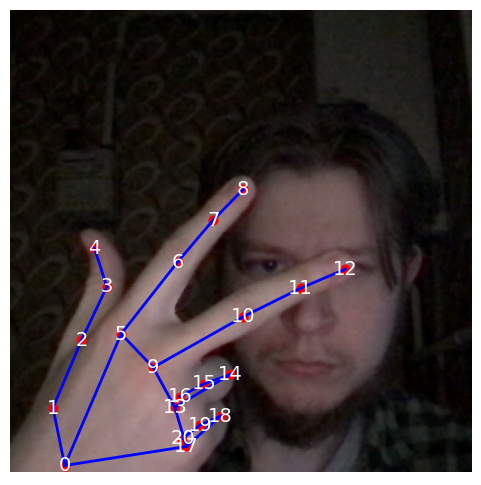

In [46]:
def imprimir_landmarks(subdataset: str, label: str, image_name: str):
    image_path = f'hands/{subdataset}/{label}/{image_name}'
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        results = hands.process(img_rgb)

    hand_landmarks = results.multi_hand_landmarks[0]
### Debes encontrar una forma de procesar las coordenadas X, Y y las conexiones de las manos (Hand Connections)
    x = [landmark.x for landmark in hand_landmarks.landmark]
    y = [landmark.y for landmark in hand_landmarks.landmark]

    # Obtener las conexiones de las manos de MediaPipe
    hand_connections = mp_hands.HAND_CONNECTIONS
### Ploteo de las coordenadas + landmarks.
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis("off")

    for (i, j) in hand_connections:
        plt.plot(
            [x[i] * img_rgb.shape[1], x[j] * img_rgb.shape[1]],
            [y[i] * img_rgb.shape[0], y[j] * img_rgb.shape[0]],
            c="blue", linewidth=2
        )

    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.scatter(xi * img_rgb.shape[1], yi * img_rgb.shape[0], c="red", s=40)
        plt.text(xi * img_rgb.shape[1], yi * img_rgb.shape[0], str(i),
                 fontsize=14, color="white", ha="center", va="center")

    plt.show()

imprimir_landmarks("train","scissors","glu_537.png")

### Segunda parte: Features

In [47]:
import numpy as np
import pandas as pd

def calculate_features(row):
    landmarks = [(row[f'x{i}'], row[f'x{i+1}'], row[f'x{i+2}']) for i in range(0, 21*3, 3)]

    # Calculate distances
    dist_8_12_x = landmarks[8][0] - landmarks[12][0]
    dist_8_12_y = landmarks[8][1] - landmarks[12][1]
    dist_12_16_x = landmarks[12][0] - landmarks[16][0]
    dist_12_16_y = landmarks[12][1] - landmarks[16][1]
    dist_0_4 = np.linalg.norm(np.array(landmarks[0]) - np.array(landmarks[4]))
    dist_12_0 = np.linalg.norm(np.array(landmarks[12]) - np.array(landmarks[0]))


    # Calculate angle between 12 and 8 with respect to the midpoint of 5 and 9
    mid_5_9 = ((landmarks[5][0] + landmarks[9][0]) / 2, (landmarks[5][1] + landmarks[9][1]) / 2)

    vec_mid_12 = np.array(landmarks[12][:2]) - np.array(mid_5_9)
    vec_mid_8 = np.array(landmarks[8][:2]) - np.array(mid_5_9)

    dot_product = np.dot(vec_mid_12, vec_mid_8)
    norm_mid_12 = np.linalg.norm(vec_mid_12)
    norm_mid_8 = np.linalg.norm(vec_mid_8)

    # Avoid division by zero
    if norm_mid_12 == 0 or norm_mid_8 == 0:
        angle_12_8_mid_5_9 = 0
    else:
        cosine_angle = dot_product / (norm_mid_12 * norm_mid_8)
        cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
        angle_12_8_mid_5_9 = np.degrees(np.arccos(cosine_angle))


    return [dist_8_12_x, dist_8_12_y, dist_12_16_x, dist_12_16_y, dist_0_4, dist_12_0, angle_12_8_mid_5_9]

# Apply the function to add new feature columns
new_features_train = df_train.apply(calculate_features, axis=1, result_type='expand')
new_features_train.columns = ['Dist_Index_Middle_x', 'Dist_Index_Middle_y', 'Dist_Middle_Ring_x', 'Dist_Middle_Ring_y', 'Dist_Wrist_Thumb', 'Dist_Middle_Wrist', 'Angle_Index_Middle_Mid_Ring_Pinky']
df_train_features = pd.concat([new_features_train, df_train['label']], axis=1)


new_features_test = df_test.apply(calculate_features, axis=1, result_type='expand')
new_features_test.columns = ['Dist_Index_Middle_x', 'Dist_Index_Middle_y', 'Dist_Middle_Ring_x', 'Dist_Middle_Ring_y', 'Dist_Wrist_Thumb', 'Dist_Middle_Wrist', 'Angle_Index_Middle_Mid_Ring_Pinky']
df_test_features = pd.concat([new_features_test, df_test['label']], axis=1)

In [49]:
print("Updated Training DataFrame:")
display(df_train_features[df_train_features["label"] == "scissors"].head())

print("\nUpdated Testing DataFrame:")
display(df_test_features.head())

Updated Training DataFrame:


,Dist_Index_Middle_x,Dist_Index_Middle_y,Dist_Middle_Ring_x,Dist_Middle_Ring_y,Dist_Wrist_Thumb,Dist_Middle_Wrist,Angle_Index_Middle_Mid_Ring_Pinky,label
614,0.081780,0.314085,0.645605,-0.435739,0.591367,0.890749,42.173085,scissors
615,0.285428,-0.138678,0.133637,0.424755,0.474919,0.744313,39.387412,scissors
616,0.209005,0.253444,0.274054,-0.471711,0.476124,0.643420,53.704838,scissors
617,0.112153,-0.295214,-0.427610,-0.087282,0.411434,0.718299,44.233272,scissors
618,-0.255105,0.105462,-0.302796,-0.642480,0.367588,0.870910,33.698253,scissors



Updated Testing DataFrame:


,Dist_Index_Middle_x,Dist_Index_Middle_y,Dist_Middle_Ring_x,Dist_Middle_Ring_y,Dist_Wrist_Thumb,Dist_Middle_Wrist,Angle_Index_Middle_Mid_Ring_Pinky,label
0,0.005282,0.043228,-0.046974,0.016375,0.251282,0.441765,10.370543,paper
1,0.099191,0.006414,0.044203,-0.076415,0.444749,0.718571,10.813634,paper
2,-0.004405,-0.062348,0.071137,-0.025542,0.381250,0.591501,9.145387,paper
3,0.072731,-0.041981,-0.018134,-0.066019,0.396142,0.631992,9.589231,paper
4,0.008757,0.043412,-0.037917,0.020924,0.250487,0.388239,11.459276,paper


### Tercera Parte: Modelos de ML


Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Prepare the data
X_train = df_train_features.drop('label', axis=1)
y_train = df_train_features['label']
X_test = df_test_features.drop('label', axis=1)
y_test = df_test_features['label']

# Initialize and train the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Model Performance:")
print(f"Accuracy: {accuracy_dt}")
print("Classification Report:")
print(report_dt)

Decision Tree Model Performance:
Accuracy: 0.8869395711500975
Classification Report:
              precision    recall  f1-score   support

       paper       0.87      0.88      0.87       170
        rock       0.85      0.99      0.91       183
    scissors       0.98      0.78      0.86       160

    accuracy                           0.89       513
   macro avg       0.90      0.88      0.88       513
weighted avg       0.90      0.89      0.89       513



SVM

In [51]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print("Support Vector Machine Model Performance:")
print(f"Accuracy: {accuracy_svm}")
print("Classification Report:")
print(report_svm)

Support Vector Machine Model Performance:
Accuracy: 0.6491228070175439
Classification Report:
              precision    recall  f1-score   support

       paper       0.67      0.93      0.78       170
        rock       0.56      0.45      0.50       183
    scissors       0.72      0.57      0.64       160

    accuracy                           0.65       513
   macro avg       0.65      0.65      0.64       513
weighted avg       0.65      0.65      0.64       513



Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:")
print(report_rf)

Random Forest Model Performance:
Accuracy: 0.9181286549707602
Classification Report:
              precision    recall  f1-score   support

       paper       0.95      0.86      0.90       170
        rock       0.84      0.98      0.90       183
    scissors       1.00      0.91      0.95       160

    accuracy                           0.92       513
   macro avg       0.93      0.92      0.92       513
weighted avg       0.93      0.92      0.92       513



### Bonus

In [ ]:
### Empieza a escribir tu código aquí